
This notebook explores serve performance in ATP men's singles tennis from 2010 to 2024. It analyzes how serving metrics evolve across tournament rounds, surfaces, and player characteristics using fixed effects regression and PCA.

The project addresses the question: "Is it the match or is it the moment?" by investigating how much of a player's serve performance is determined by factors such as surface, opponent, and round difficulty.

Data source: ATP Tour match-level statistics (2010–2024), cleaned and processed.

In [9]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf

# Loading and merging refined yearly ATP data
years = list(range(2010, 2024))
dfs = []
for year in years:
    file_path = f'data/atp_matches_{year}.csv'
    df = pd.read_csv(file_path)
    df['year'] = year
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

# cleaning column names and dropping missing values
df_all.columns = [col.strip().lower().replace(' ', '_') for col in df_all.columns]
df_all = df_all.dropna(subset=['w_ace','w_df','w_svpt', 'w_1stin', 'w_1stwon', 'w_2ndwon', 'w_svgms','w_bpsaved','w_bpfaced', 'l_ace','l_df', 'l_svpt','l_1stin', 'l_1stwon', 'l_2ndwon', 'l_svgms','l_bpsaved','l_bpfaced', 'winner_ioc', 'loser_ioc', 'tourney_name'])

# dropping incomplete rows
df_all = df_all.dropna(subset=['w_ace','w_df','w_svpt', 'w_1stin', 'w_1stwon', 'w_2ndwon', 'w_svgms','w_bpsaved','w_bpfaced', 'l_ace','l_df', 'l_svpt','l_1stin', 'l_1stwon', 'l_2ndwon', 'l_svgms','l_bpsaved','l_bpfaced', 'winner_ioc', 'loser_ioc', 'tourney_name'])

# Mapping tournament names to host countries
tourney_to_country = {
    'Brisbane': 'AUS', 'Chennai': 'IND', 'Doha': 'QAT', 'Auckland': 'NZL',
    'Sydney': 'AUS', 'Australian Open': 'AUS', 'Johannesburg': 'RSA',
    'Santiago': 'CHI', 'Zagreb': 'CRO', 'Costa Do Sauipe': 'BRA',
    'Rotterdam': 'NED', 'San Jose': 'USA', 'Buenos Aires': 'ARG',
    'Marseille': 'FRA', 'Memphis': 'USA', 'Acapulco': 'MEX',
    'Delray Beach': 'USA', 'Dubai': 'UAE', 'Indian Wells Masters': 'USA',
    'Miami Masters': 'USA', 'Casablanca': 'MAR', 'Houston': 'USA',
    'Monte Carlo Masters': 'MCO', 'Barcelona': 'ESP', 'Rome Masters': 'ITA',
    'Munich': 'GER', 'Belgrade': 'SRB', 'Estoril': 'POR',
    'Madrid Masters': 'ESP', 'Dusseldorf': 'GER', 'Nice': 'FRA',
    'Roland Garros': 'FRA', 'Halle': 'GER', "Queen's Club": 'GBR',
    'Eastbourne': 'GBR', "s Hertogenbosch": 'NED', 'Wimbledon': 'GBR',
    'Newport': 'USA', 'Atlanta': 'USA', 'Hamburg': 'GER', 'Gstaad': 'SUI',
    'Los Angeles': 'USA', 'Umag': 'CRO', 'Washington': 'USA',
    'Canada Masters': 'CAN', 'Cincinnati Masters': 'USA', 'New Haven': 'USA',
    'US Open': 'USA', 'Bucharest': 'ROU', 'Metz': 'FRA', 'Bangkok': 'THA',
    'Kuala Lumpur': 'MAS', 'Beijing': 'CHN', 'Tokyo': 'JPN',
    'Shanghai Masters': 'CHN', 'Moscow': 'RUS', 'Stockholm': 'SWE',
    'Montpelier': 'FRA', 'St. Petersburg': 'RUS', 'Vienna': 'AUT',
    'Valencia': 'ESP', 'Basel': 'SUI', 'Paris Masters': 'FRA', 'Tour Finals': 'GBR',
}

# combining all "bad" tournaments into a single regex pattern & filtering them out
pattern = 'Davis Cup|Laver Cup|Tokyo Olympics|Dusseldorf'
df_all = df_all[~df_all['tourney_name'].str.contains(pattern, case=False, na=False)]

# standardizes spacing
df_all['tourney_name'] = df_all['tourney_name'].str.strip()

# creating home dummy var
df_all['tourney_name'] = df_all['tourney_name'].str.strip()
df_all['tourney_country'] = df_all['tourney_name'].map(tourney_to_country)

# home dummy for winner
df_all['winner_home'] = (df_all['winner_ioc'] == df_all['tourney_country']).astype(int)
# home dummy for loser (if needed)
df_all['loser_home'] = (df_all['loser_ioc'] == df_all['tourney_country']).astype(int)


# saving clean data
df_all.to_csv('data/atp_matches_cleaned.csv', index=False)

# mapping round number
round_order = {'R128':1, 'R64':2,'R32':3,'R16':4,'QF':5,'SF':6,'F':7}
df_all['round_num'] = df_all['round'].map(round_order)


# winner dataframe
winner_df = df_all[['tourney_id','tourney_name','tourney_level', 'tourney_country', 'surface', 'year',
                    'winner_name', 'winner_ioc',
                    'w_ace', 'w_df', 'w_svpt', 'w_1stin', 'w_1stwon', 'w_2ndwon',
                    'w_svgms', 'w_bpsaved', 'w_bpfaced']].copy()

winner_df['home'] = (winner_df['winner_ioc'] == winner_df['tourney_country'])
winner_df.columns = ['tourney_id','tourney_name','tourney_level', 'tourney_country', 'surface', 'year', 'player_name', 'player_ioc', 'aces', 'double_faults', 'svpt',
                     'first_in', 'first_won', 'second_won', 'service_games',
                     'break_points_saved', 'break_points_faced', 'home']

# loser dataframe
loser_df = df_all[['tourney_id', 'tourney_name','tourney_level', 'tourney_country', 'surface', 'year', 'loser_name','loser_ioc', 'l_ace','l_df', 'l_svpt','l_1stin', 'l_1stwon', 'l_2ndwon', 'l_svgms','l_bpsaved','l_bpfaced']].copy()
loser_df['home'] = (loser_df['loser_ioc'] == loser_df['tourney_country'])
loser_df.columns = ['tourney_id', 'tourney_name', 'tourney_level', 'tourney_country', 'surface', 'year',
                    'player_name', 'player_ioc', 'aces', 'double_faults', 'svpt',
                    'first_in', 'first_won', 'second_won', 'service_games',
                    'break_points_saved', 'break_points_faced', 'home']

frames = [winner_df, loser_df]
player_df = pd.concat(frames, ignore_index=True)
player_df.columns = [col.strip().lower().replace(' ', '_') for col in player_df.columns]
# dropping matches with 0 or missing serve games
player_df = player_df[player_df['service_games'] > 0]

# grouping tournaments with the same length
player_df = player_df.merge(df_all[['tourney_id', 'round', 'round_num']], on='tourney_id', how='left')

# first serve percentage metric
player_df['first_serve_pct'] = player_df['first_in'] / player_df['svpt']

# player/tourney id tracking
player_df['player_tourney_id'] = player_df['player_name'] + '_' + player_df['tourney_id']

player_df = player_df.dropna(subset=['first_serve_pct', 'round_num'])
grouped = player_df.groupby(['player_tourney_id', 'round_num']).agg({'first_serve_pct': 'mean'}).reset_index()

# grouping
grouped = player_df.groupby(['player_tourney_id', 'round_num']).agg({'first_serve_pct': 'mean'}). reset_index()


Pooled OLS Model was used initially, but findings concluded it doesn't do well at explaining variation in serve performance.

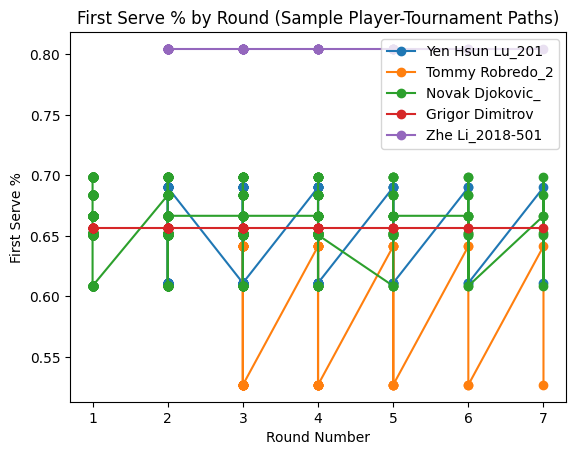

Intercept: 0.614749072602903
Coefficients: -0.00034158331655912794
R-squared: 4.313656988597092e-05


In [10]:
# cleaning
player_df = player_df.dropna(subset = ['first_in', 'svpt'])
player_df = player_df[player_df['svpt'] > 0]

sample_ids = grouped['player_tourney_id'].drop_duplicates().sample(5,random_state=1)

for ptid in sample_ids:
    temp = player_df[player_df['player_tourney_id']==ptid].sort_values('round_num')
    plt.plot(temp['round_num'], temp['first_serve_pct'], marker = 'o', label=ptid[:15])
plt.xlabel('Round Number')
plt.ylabel('First Serve %')
plt.title('First Serve % by Round (Sample Player-Tournament Paths)')
plt.legend()
plt.show()

df_model = player_df.dropna(subset = ['first_serve_pct', 'round_num'])
X = df_model[['round_num']]
y = df_model['first_serve_pct']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_[0])
print("R-squared:", r2_score(y, y_pred))

player_df['first_in'] = player_df['first_in'].astype(float)
player_df['svpt'] = player_df['svpt'].astype(float)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# polynomial features (degree 2 = quadratic)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_model[['round_num']])

# fitting model
poly_model = LinearRegression()
poly_model.fit(X_poly, y)
y_pred_poly = poly_model.predict(X_poly)

# results
print("Intercept:", poly_model.intercept_)
print("Coefficients:", dict(zip(poly.get_feature_names_out(['round_num']), poly_model.coef_)))
print("R-squared (Polynomial):", r2_score(y, y_pred_poly))


Switch to Fixed Effects Model

In [12]:
# cleaning
fe_df = player_df.dropna(subset=['first_serve_pct', 'round_num', 'player_name'])

# Top 25 players
top_players = fe_df['player_name'].value_counts().head(25).index
fe_sample = fe_df[fe_df['player_name'].isin(top_players)]

# sample max: 1000 total observations (too large to run)
fe_sample = fe_sample.sample(1000, random_state=1)

# fixed effects regression
model_fe = smf.ols('first_serve_pct ~ round_num + C(player_name)', data=fe_sample).fit()
print(model_fe.summary())


                            OLS Regression Results                            
Dep. Variable:        first_serve_pct   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     8.948
Date:                Sun, 03 Aug 2025   Prob (F-statistic):           5.91e-30
Time:                        15:26:52   Log-Likelihood:                 1269.1
No. Observations:                1000   AIC:                            -2486.
Df Residuals:                     974   BIC:                            -2359.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [13]:
# baseline pooled OLS model
model_pooled = smf.ols('first_serve_pct ~ round_num', data=fe_sample).fit()

# fixed effects model with player dummies
model_fe = smf.ols('first_serve_pct ~ round_num + C(player_name)', data=fe_sample).fit()

# F-test
f_stat, p_value, df_diff = model_fe.compare_f_test(model_pooled)

print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4e}")  # scientific notation for small p-values
print(f"Degrees of freedom (difference): {int(df_diff)}")

# model refinement
print("Pooled OLS AIC", model_pooled.aic)
print("Fixed Effects AIC", model_fe.aic)
print("Pooled OLS BIC", model_pooled.bic)
print("Fixed Effects BIC", model_fe.bic)

F-statistic: 9.2822
p-value: 2.9488e-30
Degrees of freedom (difference): 24
Pooled OLS AIC -2328.268741120519
Fixed Effects AIC -2486.240655186619
Pooled OLS BIC -2318.4532305625544
Fixed Effects BIC -2358.6390179330833


In [ ]:
# extracting round number coefficient
print("Coefficient for Round Number: ", model_fe.params['round_num'])

# control for surface
# surface dummies from full fixed effects data
fe_df['surface'] = pd.Categorical(fe_df['surface'], categories=['Hard', 'Clay', 'Grass'], ordered=False)
surface_dummies = pd.get_dummies(fe_df['surface'], drop_first=True)  # Drops 'Hard' baseline
fe_surface_df = pd.concat([fe_df, surface_dummies], axis=1)

# filtering top players for sampling
top_players = fe_surface_df['player_name'].value_counts().head(25).index
fe_surface_sample = fe_surface_df[fe_surface_df['player_name'].isin(top_players)]
fe_surface_sample = fe_surface_sample.sample(1000, random_state=1)

# fixed effects model with surface controls
model_fe_surface = smf.ols(
    formula='first_serve_pct ~ round_num + Clay + Grass + C(player_name)',
    data=fe_surface_sample
).fit()

print(model_fe_surface.summary())

# f-test comparing original fixed effects model and version with surface control
f_stat, p_value, df_diff = model_fe_surface.compare_f_test(model_fe)
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")

# f-test comparing the addition of clay and grass surface controls
model_fe_refit = smf.ols('first_serve_pct ~ round_num + C(player_name)', data=fe_surface_sample).fit()
f_stat, p_value, df_diff = model_fe_surface.compare_f_test(model_fe_refit)
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")
# AIC & BIC for Model Quality
print("AIC without surface:", model_fe_refit.aic)
print("AIC with surface:", model_fe_surface.aic)
print("BIC without surface:", model_fe_refit.bic)
print("BIC with surface:", model_fe_surface.bic)

In [ ]:
# adding year and tournament-level controls
model_fe_controls = smf.ols(
    'first_serve_pct ~ round_num + C(surface) + C(year) + C(tourney_level) + C(player_name)',
    data=fe_surface_sample
).fit()

print(model_fe_controls.summary())

# AIC, BIC, and R^2 for Quality Control
print("AIC:", model_fe_controls.aic)
print("BIC:", model_fe_controls.bic)
print("R-squared (adj):", model_fe_controls.rsquared_adj)

In [ ]:
# ensuring surface is categorical for sample
fe_sample['surface'] = pd.Categorical(fe_sample['surface'], categories =['Hard', 'Clay', 'Grass'])
model_fe_interaction = smf.ols(
    'first_serve_pct ~ round_num * surface + C(player_name)',
    data=fe_sample
).fit()
print(model_fe_interaction.summary())

# Model Comparison
f_stat, p_value, df_diff = model_fe_interaction.compare_f_test(model_fe_surface)
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")

# AIC, BIC, and Adj. R^2 for Quality Control
print("AIC:", model_fe_interaction.aic)
print("BIC:", model_fe_interaction.bic)
print("Adjusted R-squared:", model_fe_interaction.rsquared_adj)

In [ ]:
# double faults per game metric & cleaning
player_df['double_faults_per_game'] = player_df['double_faults'] / player_df['service_games']
player_df.dropna(subset =['double_faults_per_game','round_num'])

# sample creation
top_players = player_df['player_name'].value_counts().head(25).index
fe_df= player_df[player_df['player_name'].isin(top_players)].copy()
fe_sample = fe_df.sample(1000, random_state=1)

# model: two separate ones here because the surface model is a nested subset of the full model, and we want to compare based on the full model not a subset of it. If not, f_stat becomes -inf and p_value = nan
model_fe_doubles_a = smf.ols(
    formula = 'double_faults_per_game ~ round_num + C(player_name)',
    data = fe_sample
).fit()
print(model_fe_doubles_a.summary())


# AIC, BIC, and Adj. R-squared for Quality Control
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")
print("AIC:", model_fe_doubles_a.aic)
print("BIC:", model_fe_doubles_a.bic)
print("Adjusted R-squared:", model_fe_doubles_a.rsquared_adj)




In [ ]:
# double faults per game metric & cleaning
player_df['double_faults_per_game'] = player_df['double_faults'] / player_df['service_games']
player_df.dropna(subset =['double_faults_per_game','round_num'])

# sample creation
top_players = player_df['player_name'].value_counts().head(25).index
fe_df= player_df[player_df['player_name'].isin(top_players)].copy()
fe_sample = fe_df.sample(1000, random_state=1)

# model: two separate ones here because the surface model is a nested subset of the full model, and we want to compare based on the full model not a subset of it. If not, f_stat becomes -inf and p_value = nan
model_fe_double_b = smf.ols(
    formula = 'double_faults_per_game ~ round_num + +C(surface, Treatment(reference = "Hard")) + C(player_name)',
    data=fe_sample
).fit()
print(model_fe_double_b.summary())

# f-test
f_stat, p_value, df_diff = model_fe_doubles_a.compare_f_test(model_fe_double_b)
print(f"F-statistic: {f_stat:.4f}")

# AIC, BIC, and Adj. R-squared for Quality Control
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")
print("AIC:", model_fe_doubles_a.aic)
print("BIC:", model_fe_doubles_a.bic)
print("Adjusted R-squared:", model_fe_doubles_a.rsquared_adj)

In [ ]:
# break points saved % metric & cleaning
player_df = player_df.dropna(subset=['break_points_saved', 'break_points_faced'])
player_df = player_df[player_df['break_points_faced'] > 0]
player_df['break_points_saved_pct'] = player_df['break_points_saved'] / player_df['break_points_faced']

# sample creation
top_players = player_df['player_name'].value_counts().head(25).index
fe_df= player_df[player_df['player_name'].isin(top_players)].copy()
fe_sample = fe_df.sample(1000, random_state=1)

# model: two separate ones here because the surface model is a nested subset of the full model, and we want to compare based on the full model not a subset of it. If not, f_stat becomes -inf and p_value = nan
model_fe_bps_pct_a = smf.ols(
    formula = 'break_points_saved_pct ~ round_num + C(player_name)',
    data = fe_sample
).fit()
print(model_fe_bps_pct_a.summary())


# AIC, BIC, and Adj. R-squared for Quality Control
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")
print("AIC:", model_fe_doubles_a.aic)
print("BIC:", model_fe_doubles_a.bic)
print("Adjusted R-squared:", model_fe_bps_pct_a.rsquared_adj)


In [ ]:
# break points saved % metric & cleaning
player_df = player_df.dropna(subset=['break_points_saved', 'break_points_faced'])
player_df = player_df[player_df['break_points_faced'] > 0]
player_df['break_points_saved_pct'] = player_df['break_points_saved'] / player_df['break_points_faced']

# sample creation
top_players = player_df['player_name'].value_counts().head(25).index
fe_df= player_df[player_df['player_name'].isin(top_players)].copy()
fe_sample = fe_df.sample(1000, random_state=1)

# model: two separate ones here because the surface model is a nested subset of the full model, and we want to compare based on the full model not a subset of it. If not, f_stat becomes -inf and p_value = nan
model_fe_bps_pct_b = smf.ols(
    formula = 'break_points_saved_pct ~ round_num + C(surface, Treatment(reference = "Hard")) + C(player_name)',
    data = fe_sample
).fit()
print(model_fe_bps_pct_b.summary())

# f-test
f_stat, p_value, df_diff = model_fe_bps_pct_a.compare_f_test(model_fe_bps_pct_b)
print(f"F-statistic: {f_stat:.4f}")

# AIC, BIC, and Adj. R-squared for Quality Control
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")
print("AIC:", model_fe_doubles_a.aic)
print("BIC:", model_fe_doubles_a.bic)
print("Adjusted R-squared:", model_fe_bps_pct_a.rsquared_adj)

In [ ]:
# 1st serve win % metric creation & cleaning
player_df = player_df.dropna(subset=['first_won', 'first_in'])
player_df = player_df[player_df['first_won'] > 0]
player_df = player_df[player_df['first_in'] > 0]
player_df['first_serve_win_pct'] = player_df['first_won'] / player_df['first_in']

# sample creation
top_players = player_df['player_name'].value_counts().head(25).index
fe_df= player_df[player_df['player_name'].isin(top_players)].copy()
fe_sample = fe_df.sample(1000, random_state=1)

# model: two separate ones here because the surface model is a nested subset of the full model, and we want to compare based on the full model not a subset of it. If not, f_stat becomes -inf and p_value = nan
model_fe_1sw_pct_a = smf.ols(
    formula = 'first_serve_win_pct ~ round_num + C(player_name)',
    data = fe_sample
).fit()
print(model_fe_1sw_pct_a.summary())

# AIC, BIC, and Adj. R-squared for Quality Control
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")
print("AIC:", model_fe_1sw_pct_a.aic)
print("BIC:", model_fe_1sw_pct_a.bic)
print("Adjusted R-squared:", model_fe_1sw_pct_a.rsquared_adj)



In [ ]:
# 1st serve win % metric creation & cleaning
player_df = player_df.dropna(subset=['first_won', 'first_in'])
player_df = player_df[player_df['first_won'] > 0]
player_df = player_df[player_df['first_in'] > 0]
player_df['first_serve_win_pct'] = player_df['first_won'] / player_df['first_in']

# sample creation
top_players = player_df['player_name'].value_counts().head(25).index
fe_df= player_df[player_df['player_name'].isin(top_players)].copy()
fe_sample = fe_df.sample(1000, random_state=1)

# model: two separate ones here because the surface model is a nested subset of the full model, and we want to compare based on the full model not a subset of it. If not, f_stat becomes -inf and p_value = nan
model_fe_1sw_pct_b = smf.ols(
    formula = 'first_serve_win_pct ~ round_num + C(surface, Treatment(reference = "Hard")) + C(player_name)',
    data = fe_sample
).fit()
print(model_fe_1sw_pct_b.summary())

# f-test
f_stat, p_value, df_diff = model_fe_1sw_pct_a.compare_f_test(model_fe_1sw_pct_b)
print(f"F-statistic: {f_stat:.4f}")

# AIC, BIC, and Adj. R-squared for Quality Control
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")
print("AIC:", model_fe_1sw_pct_b.aic)
print("BIC:", model_fe_1sw_pct_b.bic)
print("Adjusted R-squared:", model_fe_1sw_pct_b.rsquared_adj)

In [ ]:
# 2nd Serve Win % metric creation & cleaning
player_df = player_df.dropna(subset=['second_won', 'svpt', 'double_faults', 'first_in'])
player_df = player_df[player_df['second_won'] > 0]
player_df = player_df[player_df['first_in'] > 0]
player_df = player_df[player_df['svpt'] > 0]
player_df = player_df[player_df['double_faults'] > 0]
player_df['second_serve_att'] = player_df['svpt'] - player_df['first_in'] - player_df['double_faults']
player_df = player_df[player_df['second_serve_att'] > 0]
player_df['second_serve_win_pct'] = player_df['second_won'] / player_df['second_serve_att']

# sample creation
top_players = player_df['player_name'].value_counts().head(25).index
fe_df= player_df[player_df['player_name'].isin(top_players)].copy()
fe_sample = fe_df.sample(1000, random_state=1)

# model: two separate ones here because the surface model is a nested subset of the full model, and we want to compare based on the full model not a subset of it. If not, f_stat becomes -inf and p_value = nan
model_fe_2sw_pct_a = smf.ols(
    formula = 'second_serve_win_pct ~ round_num + C(player_name)',
    data = fe_sample
).fit()
print(model_fe_2sw_pct_a.summary())

# AIC, BIC, and Adj. R-squared for Quality Control
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")
print("AIC:", model_fe_2sw_pct_a.aic)
print("BIC:", model_fe_2sw_pct_a.bic)
print("Adjusted R-squared:", model_fe_2sw_pct_a.rsquared_adj)


In [ ]:
# 2nd Serve Win % metric creation & cleaning
player_df = player_df.dropna(subset=['second_won', 'svpt', 'double_faults', 'first_in'])
player_df = player_df[player_df['second_won'] > 0]
player_df = player_df[player_df['first_in'] > 0]
player_df = player_df[player_df['svpt'] > 0]
player_df = player_df[player_df['double_faults'] > 0]
player_df['second_serve_att'] = player_df['svpt'] - player_df['first_in'] - player_df['double_faults']
player_df = player_df[player_df['second_serve_att'] > 0]
player_df['second_serve_win_pct'] = player_df['second_won'] / player_df['second_serve_att']

# sample creation
top_players = player_df['player_name'].value_counts().head(25).index
fe_df= player_df[player_df['player_name'].isin(top_players)].copy()
fe_sample = fe_df.sample(1000, random_state=1)

# model: two separate ones here because the surface model is a nested subset of the full model, and we want to compare based on the full model not a subset of it. If not, f_stat becomes -inf and p_value = nan
model_fe_2sw_pct_b = smf.ols(
    formula = 'second_serve_win_pct ~ round_num + C(surface, Treatment(reference = "Hard")) + C(player_name)',
    data = fe_sample
).fit()
print(model_fe_2sw_pct_b.summary())

# f-test
f_stat, p_value, df_diff = model_fe_2sw_pct_a.compare_f_test(model_fe_2sw_pct_b)
print(f"F-statistic: {f_stat:.4f}")

# AIC, BIC, and Adj. R-squared for Quality Control
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")
print("AIC:", model_fe_2sw_pct_b.aic)
print("BIC:", model_fe_2sw_pct_b.bic)
print("Adjusted R-squared:", model_fe_2sw_pct_b.rsquared_adj)

Composite Serve Performance Index via PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: Define which raw variables go into the serve performance index
performance_cols = [
    'aces',
    'double_faults',
    'first_serve_pct',
    'second_serve_pct',
    'break_points_saved_pct',
    'first_serve_win_pct',
    'second_serve_win_pct'
]

# Step 2: Create a new DataFrame with relevant columns and drop missing rows
metrics = player_df[['player_name', 'tourney_id', 'round_num', 'surface', 'year'] + performance_cols].copy()
metrics = metrics.dropna()

# Step 3: Z-score standardize the numerical performance metrics
scaler = StandardScaler()
scaled_array = scaler.fit_transform(metrics[performance_cols])

# Step 4: Assign back to a DataFrame with z_ column names
z_colnames = [f'z_{col}' for col in performance_cols]
scaled_df = pd.DataFrame(scaled_array, columns=z_colnames)

# Step 5: Add back identifiers (player, surface, round, etc.)
scaled_df_with_ids = pd.concat([metrics[['player_name', 'tourney_id', 'round_num', 'surface', 'year']].reset_index(drop=True), scaled_df], axis=1)

# Step 6: Run PCA on the scaled performance metrics
pca = PCA(n_components=1)
serve_index_scores = pca.fit_transform(scaled_df[z_colnames])

# Step 7: Save the PCA-based index and inspect weights
scaled_df_with_ids['serve_performance_index'] = serve_index_scores
weights = pd.Series(pca.components_[0], index=z_colnames)
print("PCA Weights (Loadings):")
print(weights.sort_values())

# Optional: visualize loading weights
weights.sort_values().plot(kind='barh', title='PCA Loadings for Serve Performance Index')
plt.xlabel('Loading Weight')
plt.tight_layout()
plt.show()

Matrix Correlation Heatmap

In [ ]:
# heatmap to look at correlation across all metrics
corr_matrix = metrics[num_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Serve Metrics')
plt.show()


Regression on Serve Performance Index

In [ ]:
# checking for proper columns
print(scaled_df_with_ids.columns)

# dropping NANs
fe_df = scaled_df_with_ids.dropna(subset = ['serve_performance_index', 'round_num', 'player_name', 'surface'])
# Sampling top 25 most active players
top_players = fe_df['player_name'].value_counts().head(25).index
fe_sample = fe_df[fe_df['player_name'].isin(top_players)].sample(1000, random_state = 1)

print(fe_sample.shape)
print(fe_sample['player_name'].nunique())

# surface conversion
fe_sample['surface'] = pd.Categorical(
    fe_sample['surface'], categories = ['Hard', 'Clay', 'Grass'],
    ordered = False)

# regression
import statsmodels.formula.api as smf
model_perf = smf.ols(
    formula = 'serve_performance_index ~ round_num + C(surface) + C(player_name)',
    data = fe_sample
).fit()

print(model_perf.summary())

In [ ]:
model_perf = smf.ols(
    formula = 'serve_performance_index ~ round_num * C(surface) + C(player_name)',
    data = fe_sample
).fit()

print(model_perf.summary())